In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import functional as TF
import torch.nn.functional as F
import random
import torch
import torch.nn as nn
from datetime import datetime

In [2]:
class RandomRotatePair:
        def __init__(self, degrees):
            self.degrees = degrees

        def __call__(self, image, mask):
            angle = random.uniform(-self.degrees, self.degrees)
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle, interpolation=transforms.InterpolationMode.NEAREST)
            return image, mask
        
class SemiSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, annotation_path, transform=None, mask_transform=None):
        with open(annotation_path, 'r') as f:
            self.annotations = json.load(f)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

        # Each annotation should have 'image' and 'mask' keys
        self.samples = [
            (ann['image'], ann['mask'])
            for ann in self.annotations
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_name = ann['image']
        mask_name = ann['mask']
        class_id = ann['class_id']  # image-level class, not per-pixel mask classes
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)  # PIL image, probably grayscale or palette

        # Apply paired random rotation
        image, mask = RandomRotatePair(360)(image, mask)

        if self.transform:
            image = self.transform(image)
        
        if self.mask_transform:
            mask = self.mask_transform(mask)  # e.g. Resize + PILToTensor + convert to 2D
            # mask is now a tensor of shape (H, W) or possibly (1, H, W)
            if mask.dim() == 3 and mask.size(0) == 1:
                mask = mask.squeeze(0)  # remove channel dim to get (H, W)
            mask = mask.long()
        else:
            # fallback: convert PIL mask to numpy int64 array, then tensor
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))
        
        return image, class_id, mask


# Example usage:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Add more transforms as needed
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),  # Keeps mask as integer labels
    transforms.Lambda(lambda x: x[0] if x.shape[0] == 1 else x.max(dim=0)[0]),  # get 2D mask
])

dataset = SemiSegmentationDataset(
    images_dir='train-semi',
    masks_dir='train-semi-segmentation',
    annotation_path='train_semi_annotations_with_seg_ids.json',
    transform=image_transform,
    mask_transform=mask_transform
)

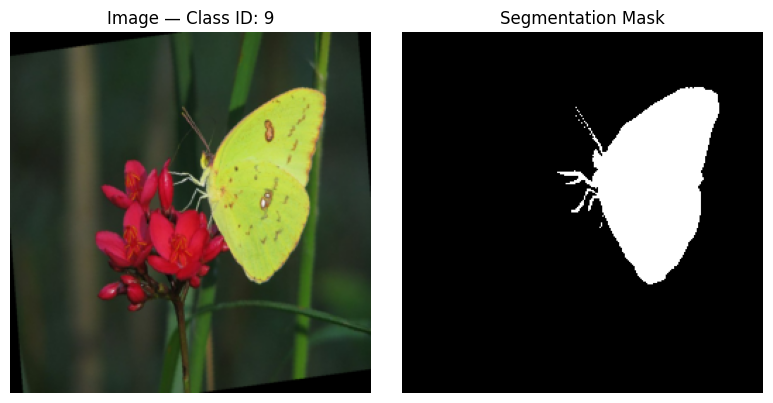

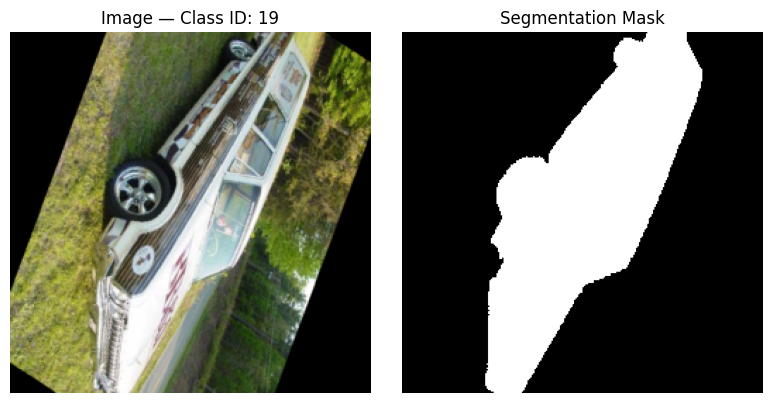

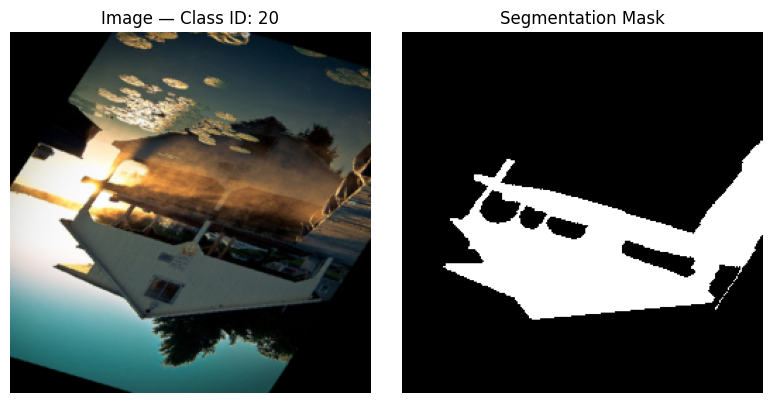

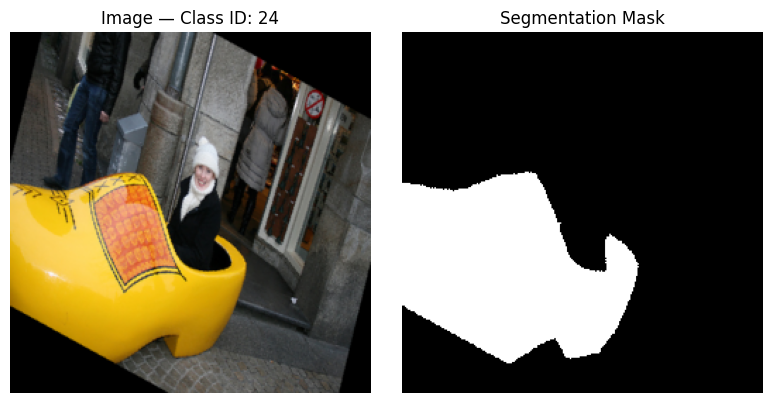

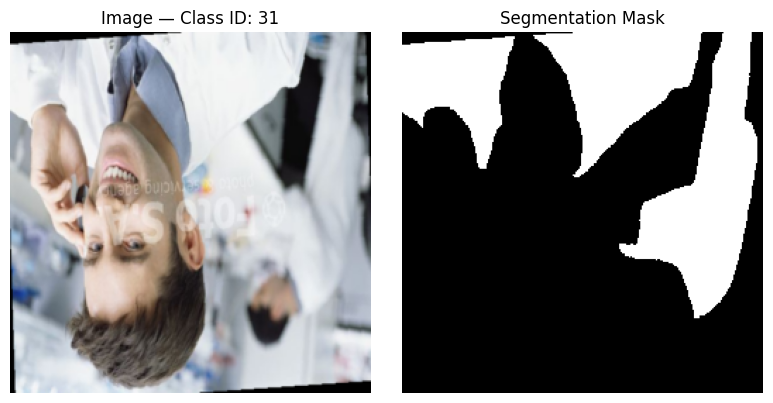

In [3]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    # Convert tensor to PIL image, then to numpy array for imshow
    img_np = np.array(to_pil_image(image.cpu()))
    axs[0].imshow(img_np)
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask.cpu(), cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

images, class_ids, masks = next(iter(dataloader))
for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])

In [4]:
# all_classes = set()

# for i in range(len(dataset)):
#     _, id, mask = dataset[i]  # adjust if your dataset returns more than (image, mask)
#     unique = torch.unique(mask)
#     all_classes.update(unique.cpu().numpy().tolist())

# print(f"Total unique classes: {len(all_classes)}")
# print(sorted(all_classes))


In [5]:
# # finds 232 in masks
# def plot_segmentation(image, mask, idx, class_id=None):
#     fig, axs = plt.subplots(1, 2, figsize=(10, 5))
#     img_np = np.array(to_pil_image(image.cpu()))
#     axs[0].imshow(img_np)
#     title = f"Sample {idx}"
#     if class_id is not None:
#         title += f" — Class ID: {class_id}"
#     axs[0].set_title(title)
#     axs[0].axis("off")

#     axs[1].imshow(mask.cpu(), cmap="tab20")  # Use a categorical colormap for classes
#     axs[1].set_title("Segmentation Mask")
#     axs[1].axis("off")
#     plt.tight_layout()
#     plt.show()

# # Iterate through all samples in the batch
# images, class_ids, masks = next(iter(dataloader))
# batch_size = images.size(0)

# for i in range(batch_size):
#     mask_classes = torch.unique(masks[i])
#     contains_232 = 232 in mask_classes.tolist()
#     class_info = f"Contains class 232" if contains_232 else None
#     plot_segmentation(images[i], masks[i], i, class_info)


In [6]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        # Ensure parameters are on the same device as input
        weight = self.weight.to(x.device)
        bias = self.bias.to(x.device)
        
        # Compute mean and variance over channel dimension (dim=1)
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)

        return weight[:, None, None] * x + bias[:, None, None]

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm2d(dim)
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.act = nn.GELU()
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        return x + shortcut

class DownsampleLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.BatchNorm2d(in_channels),  # Use BatchNorm2d for 2D feature maps
            nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.down(x)

class ConvNeXtEncoder(nn.Module):
    def __init__(self, dims=[64, 128, 256, 512], depths=[3, 3, 9, 3]):
        super().__init__()
        self.stem = nn.Conv2d(3, dims[0], kernel_size=4, stride=4)

        self.stages = nn.ModuleList()
        in_channels = dims[0]
        for i in range(4):
            stage = nn.Sequential(
                *[ConvNeXtBlock(dims[i]) for _ in range(depths[i])]
            )
            self.stages.append(stage)
            if i < 3:
                self.stages.append(DownsampleLayer(dims[i], dims[i + 1]))

    def forward(self, x):
        x = self.stem(x)
        features = []
        for layer in self.stages:
            x = layer(x)
            if isinstance(layer, nn.Sequential):
                features.append(x)
        return features  # f1 (1/4), f2 (1/8), f3 (1/16), f4 (1/32)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

class ConvNeXtSegmentationModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        dims = [64, 128, 256, 512]
        self.encoder = ConvNeXtEncoder(dims=dims)

        self.decoder3 = DecoderBlock(dims[3], dims[2], dims[2])
        self.decoder2 = DecoderBlock(dims[2], dims[1], dims[1])
        self.decoder1 = DecoderBlock(dims[1], dims[0], dims[0])

        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(dims[0], dims[0], kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(dims[0], n_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.shape[-2:]  # (H, W)
        f1, f2, f3, f4 = self.encoder(x)
        x = self.decoder3(f4, f3)
        x = self.decoder2(x, f2)
        x = self.decoder1(x, f1)
        x = self.final_up(x)
        # Upsample to match input size exactly
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)
        return x

In [7]:
torch.cuda.empty_cache()

In [8]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNeXtSegmentationModel(n_classes=50).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = F.one_hot(targets, preds.size(1)).permute(0, 3, 1, 2).reshape_as(preds_flat)

        intersection = (preds_flat * targets_flat).sum(2)
        union = preds_flat.sum(2) + targets_flat.sum(2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# Combined loss
def combined_loss(preds, targets):
    targets = torch.clamp(targets, 0, preds.size(1) - 1) 
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + dice

def dice_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat == targets_flat).float().sum()
    total = preds_flat.numel() + targets_flat.numel()
    return (2.0 * intersection + smooth) / (total + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    intersection = ((preds == targets) & (targets > 0)).float().sum()
    union = ((preds > 0) | (targets > 0)).float().sum()
    return (intersection + smooth) / (union + smooth)

def validate(model, val_loader, device):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, class_id, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.long()

            outputs = model(images)
            total_loss += combined_loss(outputs, masks).item()
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    n = len(val_loader)
    print("Unique mask values:", torch.unique(masks))
    print(f"[Validation] Loss: {total_loss/n:.4f} | Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")
    return total_loss/n, total_dice/n, total_iou/n

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)
        # Only squeeze if mask has a channel dimension (B, 1, H, W)
        if masks.dim() == 4 and masks.shape[1] == 1:
            masks = masks.squeeze(1)
        masks = masks.long()
        masks = torch.clamp(masks, min=0, max=49)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_train_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    validate(model, dataloader, device)

Epoch [1/20], Train Loss: 4.7289
Unique mask values: tensor([  0,   9,  22,  39,  42, 232], device='cuda:0')
[Validation] Loss: 4.6507 | Dice: 0.6245 | IoU: 0.0160
Epoch [2/20], Train Loss: 4.4942
Unique mask values: tensor([  0,   2,  17,  22,  28, 232], device='cuda:0')
[Validation] Loss: 4.2797 | Dice: 0.7090 | IoU: 0.0000
Epoch [3/20], Train Loss: 4.2144


KeyboardInterrupt: 

In [ ]:
def save_model_with_timestamp(model, save_dir="models", model_name="my_model"):
    """
    Saves a PyTorch model to a specified directory with a timestamp in its filename.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        save_dir (str): The directory where the model should be saved.
                        Defaults to "models".
        model_name (str): The base name for the model file.
                          Defaults to "my_model".
    """
    # 1. Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # 2. Generate a timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S") # Format: YYYYMMDD_HHMMSS

    # 3. Create the full filename with path
    filename = f"{model_name}_{timestamp}.pth" # Using .pth or .pt extension
    filepath = os.path.join(save_dir, filename)

    # 4. Save the model state_dict
    torch.save(model.state_dict(), filepath)
    print(f"Model saved successfully to: {filepath}")

save_model_with_timestamp(model, save_dir="saved_models", model_name="batchSizeIncrease")

Model saved successfully to: saved_models/batchSizeIncrease_20250601_132109.pth


Unique predicted values: tensor([0], device='cuda:0')


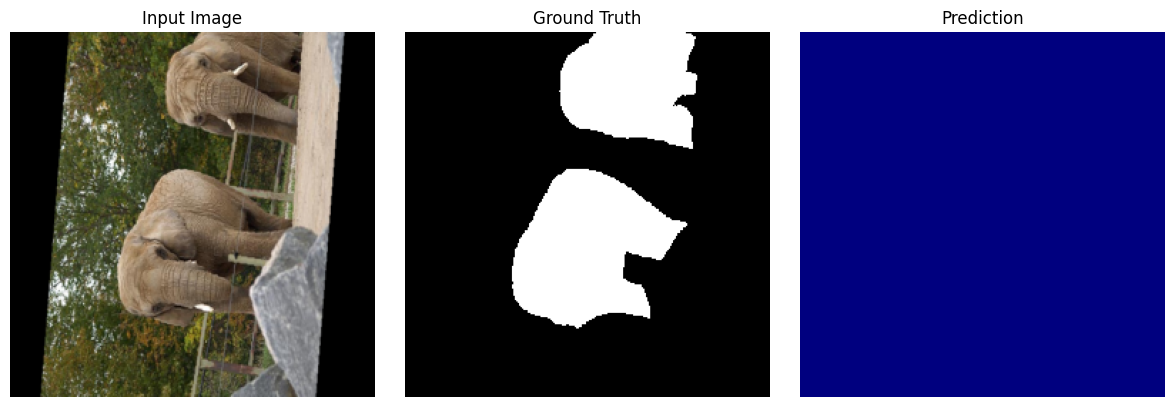

Unique predicted values: tensor([0], device='cuda:0')


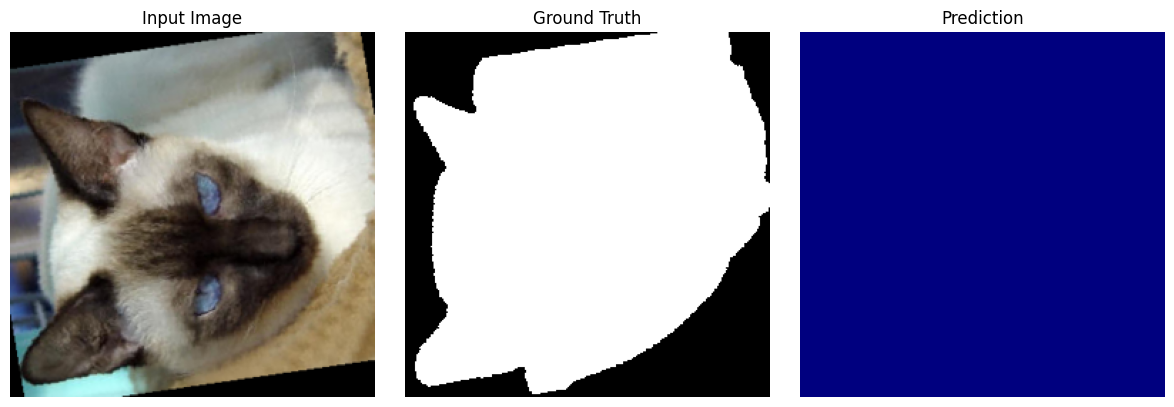

Unique predicted values: tensor([0], device='cuda:0')


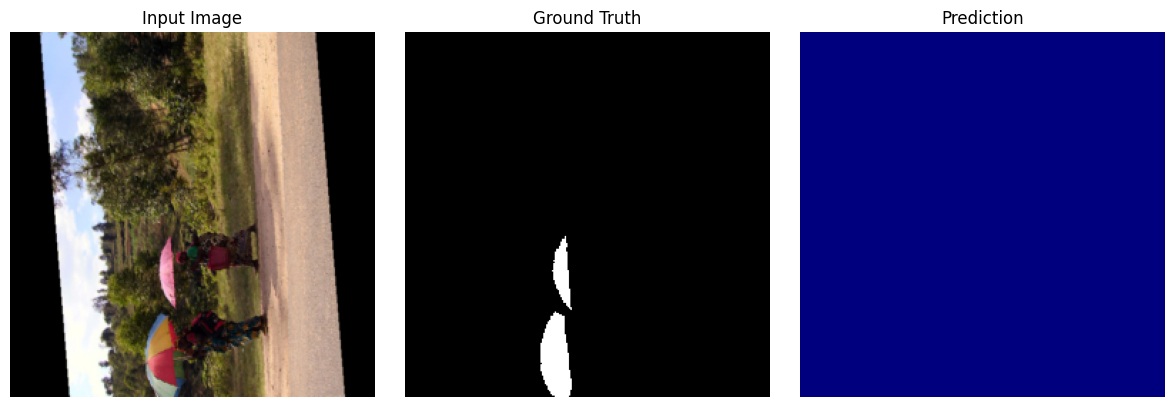

Unique predicted values: tensor([0], device='cuda:0')


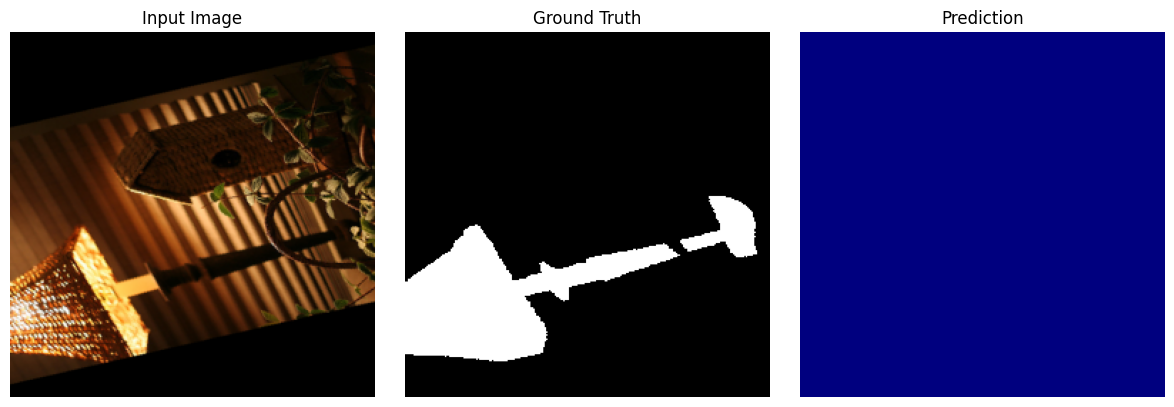

Unique predicted values: tensor([0], device='cuda:0')


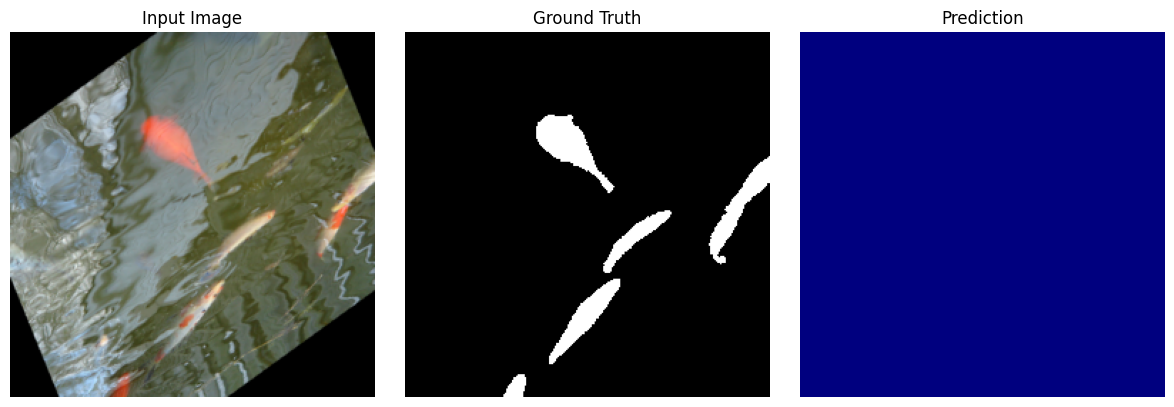

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    shown = 0
    with torch.no_grad():
        for images, class_ids, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if shown >= num_samples:
                    return
                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                print("Unique predicted values:", torch.unique(preds))
                # Input image
                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype('uint8')
                axs[0].imshow(img_np)
                axs[0].set_title("Input Image")
                axs[0].axis("off")
                # Ground truth mask
                axs[1].imshow(masks[i].cpu(), cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[1].axis("off")
                # Predicted mask
                axs[2].imshow(preds[i].cpu(), cmap='jet')
                axs[2].set_title("Prediction")
                axs[2].axis("off")
                plt.tight_layout()
                plt.show()
                shown += 1

# Example usage:
visualize_predictions(model, dataloader, device, num_samples=5)

In [ ]:
# # Get a single batch from your dataloader
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# images, class_ids, masks = next(iter(dataloader))
# images, masks = images.to(device), masks.to(device)
# if masks.dim() == 4 and masks.shape[1] == 1:
#     masks = masks.squeeze(1)
# masks = masks.long()

# # Use a fresh model and optimizer for this test
# model = ConvNeXtSegmentationModel(n_classes=233).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Use a higher LR for faster overfitting

# # Train on this single batch for many epochs
# for epoch in range(100):  # 100+ epochs, should reach near-zero loss
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(images)
#     loss = combined_loss(outputs, masks)
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

#     # Optionally visualize predictions every 10 epochs
#     if (epoch+1) % 10 == 0:
#         preds = torch.argmax(outputs, dim=1)
#         print("Unique predicted values:", torch.unique(preds))
#         visualize_predictions(model, [(images, class_ids, masks)], device, num_samples=images.size(0))
# def visualize_batch_predictions(model, images, masks, device, num_samples=4, class_labels=None):
#     model.eval()
#     with torch.no_grad():
#         images = images.to(device)
#         outputs = model(images)
#         preds = torch.argmax(outputs, dim=1).cpu()
    
#     images = images.cpu()
#     masks = masks.cpu()

#     for i in range(min(num_samples, images.size(0))):
#         img = images[i].permute(1, 2, 0).numpy()  # CHW → HWC
#         img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1] for display

#         fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#         axes[0].imshow(img)
#         axes[0].set_title("Input Image")
#         axes[1].imshow(masks[i], cmap='tab20')
#         axes[1].set_title("Ground Truth")
#         axes[2].imshow(preds[i], cmap='tab20')
#         axes[2].set_title("Prediction")

#         for ax in axes:
#             ax.axis("off")
#         plt.tight_layout()
#         plt.show()
# visualize_batch_predictions(model, images, masks, device, num_samples=5, class_labels=None)